In [248]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from numpy import genfromtxt
from scipy import stats

In [249]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    # 아래꺼 np.c_만 하면 되는거 아닌가? reshape는 왜하지
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [250]:
# np.loadtxt를 쓰자
def read_student():
    xy = np.loadtxt('winequality-red.csv', delimiter=';', skiprows=1)
    x_data = xy[:, 0:-1]
    y_data = xy[:, [-1]]
    return x_data, y_data

def read_student_as_pandas():
    df = pd.read_csv('student-mat.csv', sep=';')
    return df

In [251]:
df = read_student_as_pandas()
df.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10
394,MS,M,19,U,LE3,T,1,1,other,at_home,...,3,2,3,3,3,5,5,8,9,9


In [252]:
# pandas categorical column to numeric
# https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
str_columns = df.select_dtypes(['object']).columns
for col in str_columns:
    df[col] = df[col].astype('category')

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
390,1,1,20,1,1,0,2,2,3,3,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,1,1,1,3,1,3,3,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,0,0,1,1,1,2,2,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,0,1,1,3,2,3,2,...,4,4,1,3,4,5,0,11,12,10
394,1,1,19,1,1,1,1,1,2,0,...,3,2,3,3,3,5,5,8,9,9


In [253]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1:].values
print stats.describe(features).variance
print features.shape, labels.shape

[  1.03154919e-01   2.49926107e-01   1.62828504e+00   1.73591210e-01
   2.05834351e-01   9.32596543e-02   1.19844503e+00   1.18418043e+00
   1.50668894e+00   7.45704556e-01   1.45983422e+00   2.88029300e-01
   4.86512883e-01   7.04324359e-01   5.53016771e-01   1.12728908e-01
   2.37910429e-01   2.48885176e-01   2.50555805e-01   1.63426075e-01
   4.81912228e-02   1.39523228e-01   2.23067532e-01   8.03996659e-01
   9.97725374e-01   1.23938829e+00   7.93420292e-01   1.65867763e+00
   1.93294352e+00   6.40495406e+01   1.10170533e+01   1.41489173e+01]
(395, 32) (395, 1)


In [254]:
normalized_features = feature_normalize(features)
print stats.describe(normalized_features).variance

[ 1.00253807  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807
  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807
  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807
  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807
  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807  1.00253807
  1.00253807  1.00253807]


In [255]:
feature_count = normalized_features.shape[1]
label_count = labels.shape[1]

print feature_count, label_count

rnd_indices = np.random.rand(len(features)) < 0.50

train_x = normalized_features[rnd_indices]
train_y = labels[rnd_indices]
test_x = normalized_features[~rnd_indices]
test_y = labels[~rnd_indices]

32 1


In [256]:
training_epochs = 2000
learning_rate = 0.01
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 21  # 0 ~ 20

# x는 float32 로 할 필요가 있나? normalized 되었기때문에 float32 써야함
X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

('one_hot', <tf.Tensor 'one_hot_20:0' shape=(?, 1, 21) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_75:0' shape=(?, 21) dtype=float32>)


In [257]:
def get_class_logits():
    weights =tf.Variable(tf.random_normal([feature_count, nb_classes]), name='weight')
    biases = tf.Variable(tf.random_normal([nb_classes]), name='bias')
    logits = tf.matmul(X, weights) + biases
    hypothesis = tf.nn.softmax(logits)
    return weights, biases, logits

In [258]:
w0, b0, h0 = get_class_logits()
# w1, b1, h1 = get_class_logits()
# w2, b2, h2 = get_class_logits()

In [259]:
# https://github.com/carpedm20/DCGAN-tensorflow/issues/99
# all_logits = tf.concat([h0, h1, h2], 1)

# Cross entropy cost/loss
# logits에는 hypothesis랑 logits 중 어느걸 넣어야되고 차이는 뭘까?
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [260]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [261]:
print train_x.shape, train_y.shape
print X.shape, Y.shape, b.shape
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y})
        cost_history = np.append(cost_history, acc)
        if step % 1000 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
#     train_yy = np.transpose(train_y.ravel())
#     print(train_yy.shape)
#     correct_prediction = tf.equal(pre, train_yy)
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     print('Train Accuracy:', sess.run(accuracy, feed_dict={X: train_x}))
    
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x}))

(183, 32) (183, 1)
(?, 32) (?, 1) (21,)
Step:     0	Loss: 10.868	Acc: 4.92%
Step:  1000	Loss: 0.226	Acc: 97.27%
Step:  2000	Loss: 0.095	Acc: 100.00%
(212,)
('Test Accuracy:', 0.19339623)


(2002,)


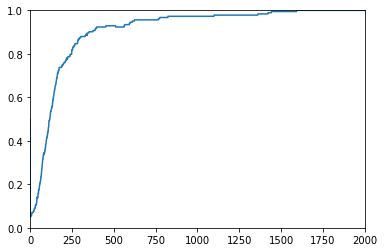

In [262]:
print cost_history.shape
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [263]:
sess.close()